In [3]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

import math
import torch
import json
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from torch_geometric.utils import to_dense_adj, stochastic_blockmodel_graph
from graspologic.embed import AdjacencySpectralEmbed 

from models.GLASE_unshared_normalized import gLASE 
from models.RDPG_GD import GRDPG_GD_Armijo
from training.get_init import get_x_init

# Load the config file
with open('../data/data_config.json', 'r') as file:
    config = json.load(file)

# SBM-5 - 5 steps

In [11]:
torch.manual_seed(42)

gd_steps = 5
device = 'cpu'
dataset = 'sbm5_unbalanced_negative'

d = config[dataset]['d']
p = config[dataset]['p']
n = np.array(config[dataset]['n'])*10
num_nodes = np.sum(n)


glase = gLASE(d, d, gd_steps)
glase.load_state_dict(torch.load(f'../saved_models/glase_{dataset}_d{d}_normalized_glase_init_{gd_steps}steps.pt'))
glase.to(device)
glase.eval()

edge_index = stochastic_blockmodel_graph(n, p).to(device)
edge_index_2 = torch.ones([num_nodes,num_nodes],).nonzero().t().contiguous().to(device)
mask = (torch.ones([num_nodes,num_nodes],)-torch.eye(num_nodes)).nonzero().t().contiguous().to(device)
x  = get_x_init(num_nodes, d, 0, math.pi/2, 0, math.pi/2).to(device)

Q_FILE = f'../data/{dataset}_q_file.pkl'
with open(Q_FILE, 'rb') as f:
    q = pickle.load(f)

Q=torch.diag(q).to(device)
print(Q)


x_glase = glase(x, edge_index, edge_index_2, Q, mask)
x_glase = x_glase.detach()
loss = torch.norm((x_glase@Q@x_glase.T - to_dense_adj(edge_index).squeeze(0))*to_dense_adj(mask).squeeze(0))
print(f"Loss GLASE shared weights ({gd_steps} layers): ", loss)
x_glase = x_glase.to('cpu')

# ## ASE EMBEDDINGS
adj_matrix = to_dense_adj(edge_index.to('cpu')).squeeze(0).numpy()
ase = AdjacencySpectralEmbed(n_components=d, diag_aug=True, algorithm='full')
x_ase = ase.fit_transform(adj_matrix)
x_ase = torch.from_numpy(x_ase)
loss = np.linalg.norm((x_ase@Q@x_ase.T - to_dense_adj(edge_index).squeeze(0).numpy())*to_dense_adj(mask).squeeze(0))
print("Loss Graspologic ASE: ", loss)

## GRPDG - GD
x_grdpg, cost, k  = GRDPG_GD_Armijo(x, edge_index, Q, mask, max_iter = 5)
x_grdpg = x_grdpg.detach()

tensor([[ 1.,  0.,  0.,  0.,  0.],
        [ 0., -1.,  0.,  0.,  0.],
        [ 0.,  0., -1.,  0.,  0.],
        [ 0.,  0.,  0., -1.,  0.],
        [ 0.,  0.,  0.,  0., -1.]])
Loss GLASE shared weights (5 layers):  tensor(1406.6929)
Loss Graspologic ASE:  1368.2831


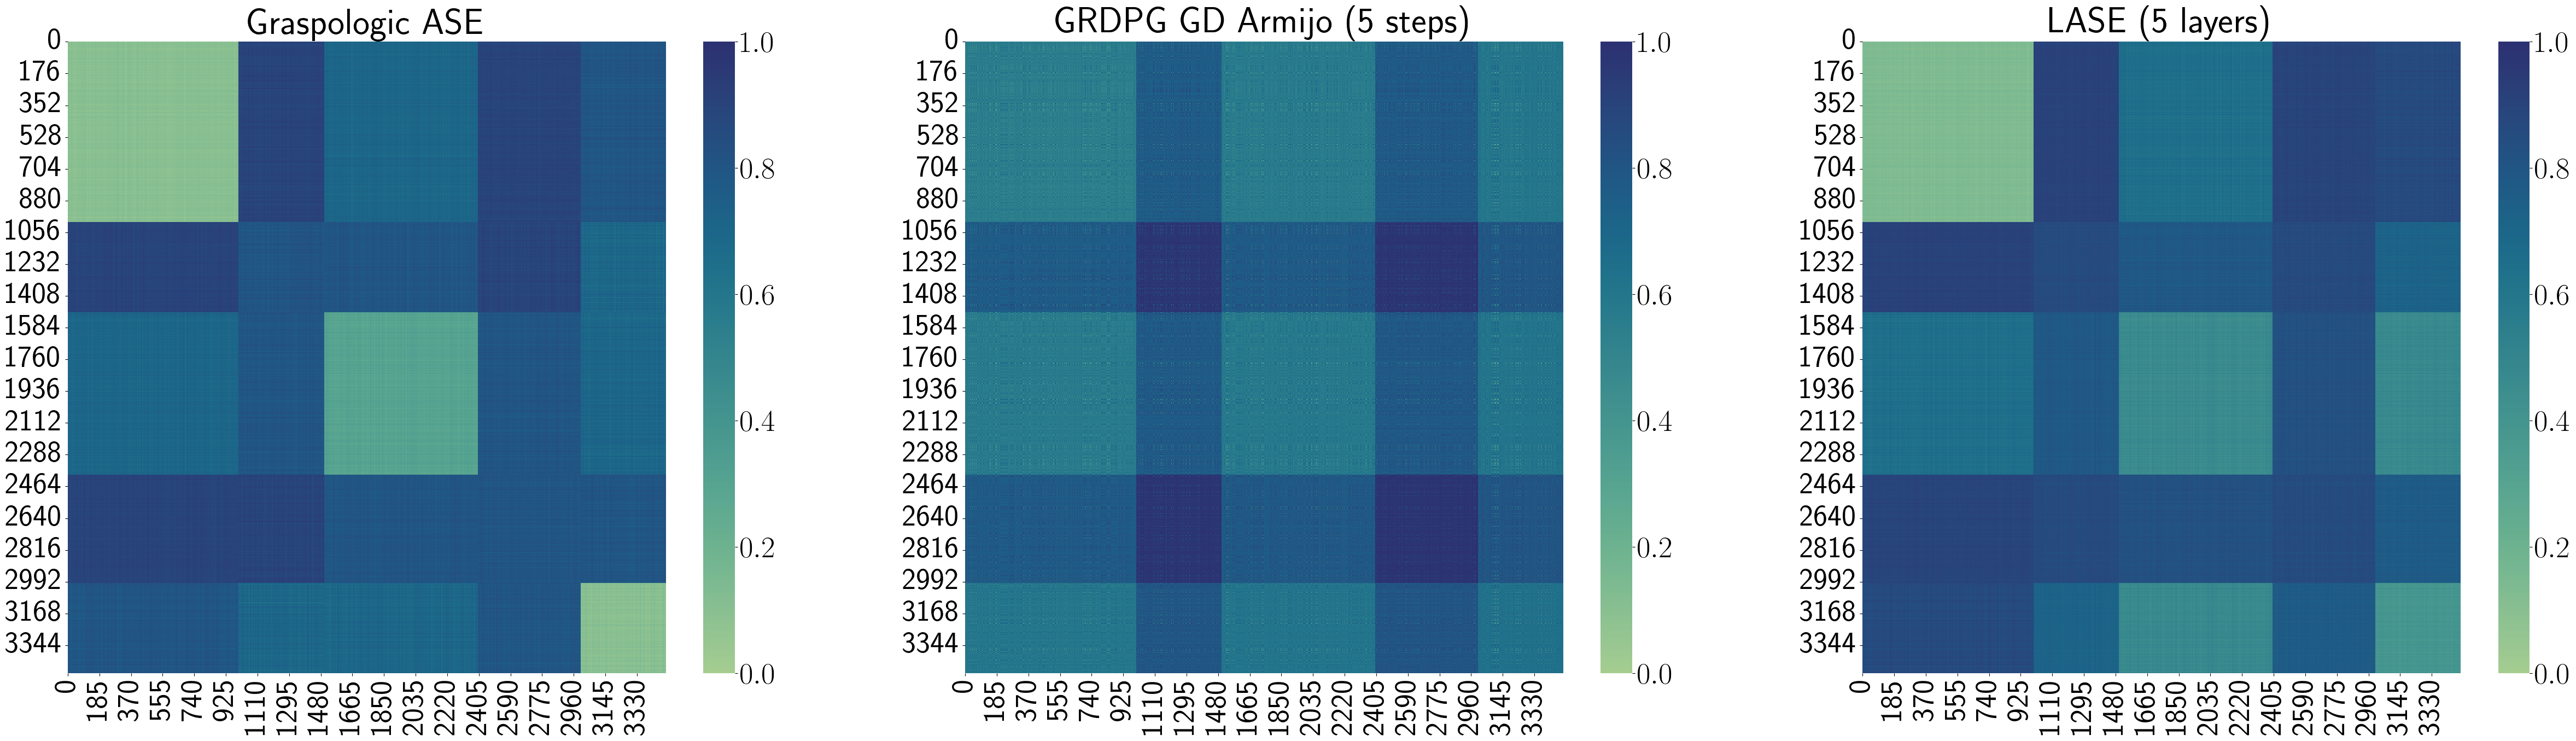

In [12]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 40
plt.rcParams['lines.markersize'] = 15
plt.rcParams['axes.grid'] = False

fig, axes = plt.subplots(1, 3, figsize =(60,15))
axes[0].set_title('Graspologic ASE')
sns.heatmap(x_ase@Q@x_ase.T, ax=axes[0], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[1].set_title('GRDPG GD Armijo (5 steps)')
sns.heatmap(x_grdpg@Q@x_grdpg.T, ax=axes[1], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
axes[2].set_title(f'LASE ({gd_steps} layers)')
sns.heatmap(x_glase@Q@x_glase.T, ax=axes[2], vmin=0.0, vmax=1.0, cbar=True, cmap="crest")
plt.show()